In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tqdm

In [2]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import keras
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
from numpy import load

In [3]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/'

In [6]:
import os 

In [7]:
!pwd

/content


In [12]:
directory = '/content/drive/MyDrive/flowers/data'
clases = os.listdir(directory)

In [13]:
clases

['dandelion', 'rose', 'sunflower', 'daisy', 'tulip']

In [14]:
directory = '/content/drive/MyDrive/flowers/data'
train_files = []
target_files = []
for flower_type in clases: 
    for file in os.listdir(os.path.join(directory, flower_type)):
        train_files.append(os.path.join(directory, flower_type, file))
        target_files.append(flower_type)

In [16]:
df = pd.DataFrame({'img' : train_files, 'target' : target_files})
df.tail()

,img,target
4312,/content/drive/MyDrive/flowers/data/tulip/9947...,tulip
4313,/content/drive/MyDrive/flowers/data/tulip/9976...,tulip
4314,/content/drive/MyDrive/flowers/data/tulip/9831...,tulip
4315,/content/drive/MyDrive/flowers/data/tulip/9870...,tulip
4316,/content/drive/MyDrive/flowers/data/tulip/9947...,tulip


In [17]:
df.head()

,img,target
0,/content/drive/MyDrive/flowers/data/dandelion/...,dandelion
1,/content/drive/MyDrive/flowers/data/dandelion/...,dandelion
2,/content/drive/MyDrive/flowers/data/dandelion/...,dandelion
3,/content/drive/MyDrive/flowers/data/dandelion/...,dandelion
4,/content/drive/MyDrive/flowers/data/dandelion/...,dandelion


In [18]:
img = []
for ind in tqdm.tqdm(range(len(df['img']))):
    origImage = cv2.imread(df['img'][ind])
    origImage = cv2.resize(origImage, (256, 256))
    img.append(origImage)
df['img'] = img

100%|██████████| 4317/4317 [10:15<00:00,  7.02it/s]


In [19]:
torch.cuda.is_available()

True

In [20]:
df.head()

,img,target
0,"[[[12, 76, 24], [11, 77, 25], [12, 79, 25], [1...",dandelion
1,"[[[197, 110, 136], [204, 117, 146], [197, 109,...",dandelion
2,"[[[1, 23, 28], [1, 23, 28], [1, 23, 28], [1, 2...",dandelion
3,"[[[13, 43, 54], [17, 45, 54], [21, 44, 54], [2...",dandelion
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",dandelion


In [21]:
df['target'].unique()

array(['dandelion', 'rose', 'sunflower', 'daisy', 'tulip'], dtype=object)

In [22]:
y = []
for i in range(len(df['target'])):
    for j in range(len(clases)):
        if df['target'][i] == clases[j]:
            y.append(j)

In [23]:
df.head()

,img,target
0,"[[[12, 76, 24], [11, 77, 25], [12, 79, 25], [1...",dandelion
1,"[[[197, 110, 136], [204, 117, 146], [197, 109,...",dandelion
2,"[[[1, 23, 28], [1, 23, 28], [1, 23, 28], [1, 2...",dandelion
3,"[[[13, 43, 54], [17, 45, 54], [21, 44, 54], [2...",dandelion
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",dandelion


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img, y, test_size=0.2, random_state=10)

In [25]:
len(y_train)

3453

In [26]:
len(y_test)

864

In [27]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt  
class MyDataset(Dataset):
    def __init__(self, data, targets,transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)
%matplotlib inline
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(X_train,y_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test,y_test, transform=transform)
testloader = DataLoader(testset, batch_size=4)

In [28]:
!pip -q install vit_pytorch linformer

     |████████████████████████████████| 48 kB 2.5 MB/s 


In [29]:
from vit_pytorch.efficient import ViT
from linformer import Linformer

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
import torch
from vit_pytorch import ViT
from vit_pytorch.mpp import MPP
model = ViT(
    image_size=256,
    patch_size=32,
    dim=1024,
    depth=6,
    heads=8,
    mlp_dim=2048,
    dropout=0.1,
    emb_dropout=0.1,
    channels = 3,
    num_classes = 5
).cuda()
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [33]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [34]:
import tqdm
error = []
for epoch in range(40):
        print('epoch: ------', epoch)
        for ind, batch in enumerate(tqdm.tqdm(trainloader)):
          imgs,  label= batch
          images = imgs
          images = images.to(device=device, dtype=torch.float32)
          label = label.to(device = device, dtype = torch.long)
          output = model(images)
          loss = criterion(output, label)
          if(ind ==0): 
            error.append(loss)
            print(loss)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

epoch: ------ 0


  0%|          | 0/864 [00:00<?, ?it/s]

tensor(1.7935, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.38it/s]


epoch: ------ 1


  0%|          | 2/864 [00:00<00:51, 16.71it/s]

tensor(1.7466, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.36it/s]


epoch: ------ 2


  0%|          | 2/864 [00:00<01:00, 14.16it/s]

tensor(1.9235, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.40it/s]


epoch: ------ 3


  0%|          | 2/864 [00:00<00:53, 16.12it/s]

tensor(1.6277, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.39it/s]


epoch: ------ 4


  0%|          | 2/864 [00:00<01:00, 14.30it/s]

tensor(1.5907, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.35it/s]


epoch: ------ 5


  0%|          | 2/864 [00:00<00:53, 16.11it/s]

tensor(1.4393, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.39it/s]


epoch: ------ 6


  0%|          | 2/864 [00:00<00:51, 16.58it/s]

tensor(1.1464, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:17<00:00, 11.18it/s]


epoch: ------ 7


  0%|          | 2/864 [00:00<00:53, 16.05it/s]

tensor(1.6108, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.35it/s]


epoch: ------ 8


  0%|          | 2/864 [00:00<00:52, 16.39it/s]

tensor(1.2599, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.41it/s]


epoch: ------ 9


  0%|          | 2/864 [00:00<00:51, 16.71it/s]

tensor(0.7013, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.37it/s]


epoch: ------ 10


  0%|          | 2/864 [00:00<00:50, 16.93it/s]

tensor(0.9756, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.37it/s]


epoch: ------ 11


  0%|          | 2/864 [00:00<00:57, 15.10it/s]

tensor(0.3678, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.41it/s]


epoch: ------ 12


  0%|          | 2/864 [00:00<00:51, 16.59it/s]

tensor(0.0844, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.40it/s]


epoch: ------ 13


  0%|          | 2/864 [00:00<00:53, 16.18it/s]

tensor(0.2991, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.41it/s]


epoch: ------ 14


  0%|          | 2/864 [00:00<00:51, 16.74it/s]

tensor(0.1157, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.40it/s]


epoch: ------ 15


  0%|          | 2/864 [00:00<00:51, 16.90it/s]

tensor(0.3453, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.40it/s]


epoch: ------ 16


  0%|          | 2/864 [00:00<00:52, 16.31it/s]

tensor(0.3246, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.39it/s]


epoch: ------ 17


  0%|          | 2/864 [00:00<00:52, 16.45it/s]

tensor(0.0458, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.41it/s]


epoch: ------ 18


  0%|          | 2/864 [00:00<00:53, 16.19it/s]

tensor(0.0331, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.40it/s]


epoch: ------ 19


  0%|          | 2/864 [00:00<00:52, 16.42it/s]

tensor(0.4285, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.41it/s]


epoch: ------ 20


  0%|          | 2/864 [00:00<00:51, 16.71it/s]

tensor(1.7492, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.40it/s]


epoch: ------ 21


  0%|          | 2/864 [00:00<00:51, 16.62it/s]

tensor(0.0239, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.40it/s]


epoch: ------ 22


  0%|          | 2/864 [00:00<00:52, 16.57it/s]

tensor(0.0393, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.40it/s]


epoch: ------ 23


  0%|          | 2/864 [00:00<00:53, 16.24it/s]

tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.41it/s]


epoch: ------ 24


  0%|          | 2/864 [00:00<00:52, 16.49it/s]

tensor(0.0059, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.40it/s]


epoch: ------ 25


  0%|          | 2/864 [00:00<00:51, 16.81it/s]

tensor(0.0272, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.41it/s]


epoch: ------ 26


  0%|          | 2/864 [00:00<00:51, 16.63it/s]

tensor(0.0746, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.41it/s]


epoch: ------ 27


  0%|          | 2/864 [00:00<00:52, 16.42it/s]

tensor(0.0304, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.41it/s]


epoch: ------ 28


  0%|          | 2/864 [00:00<00:52, 16.32it/s]

tensor(0.0319, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.41it/s]


epoch: ------ 29


  0%|          | 2/864 [00:00<00:52, 16.40it/s]

tensor(0.0975, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.41it/s]


epoch: ------ 30


  0%|          | 2/864 [00:00<00:53, 16.02it/s]

tensor(0.0038, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.40it/s]


epoch: ------ 31


  0%|          | 2/864 [00:00<00:52, 16.40it/s]

tensor(0.3128, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.41it/s]


epoch: ------ 32


  0%|          | 2/864 [00:00<00:53, 16.09it/s]

tensor(0.0051, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.42it/s]


epoch: ------ 33


  0%|          | 2/864 [00:00<00:51, 16.87it/s]

tensor(1.7281, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.42it/s]


epoch: ------ 34


  0%|          | 2/864 [00:00<00:49, 17.41it/s]

tensor(0.0135, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.43it/s]


epoch: ------ 35


  0%|          | 2/864 [00:00<00:53, 16.15it/s]

tensor(0.0064, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:09<00:00, 12.41it/s]


epoch: ------ 36


  0%|          | 2/864 [00:00<00:51, 16.73it/s]

tensor(0.0122, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 864/864 [01:11<00:00, 12.13it/s]


epoch: ------ 37


  0%|          | 2/864 [00:00<00:52, 16.36it/s]

tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward0>)


 86%|████████▌ | 739/864 [01:00<00:10, 12.28it/s]


KeyboardInterrupt: ignored

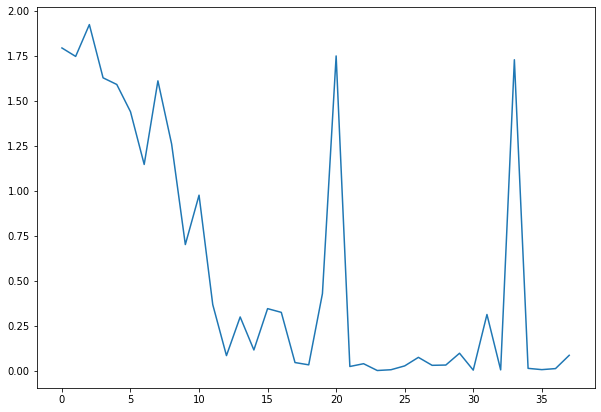

In [35]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(error)), error)
plt.show()

In [36]:
y_pred = []
y_true = []
with torch.no_grad():
    for data in tqdm.tqdm(testloader):
        img_np, label = data
        img = img_np.to(device=device, dtype=torch.float32)
        output = model(img)
        for i in range(len(output)):
          y_pred.append(output[i])
          y_true.append(label[i])

100%|██████████| 216/216 [00:04<00:00, 43.60it/s]


In [37]:
y_pred[:5]

[tensor([-6.3135,  1.0379,  4.0892, -2.7843,  2.3609], device='cuda:0'),
 tensor([ 8.2597, -1.1525, -3.5490, -0.5714, -4.3343], device='cuda:0'),
 tensor([-0.7951,  5.0126, -8.8618, -4.9161,  7.9571], device='cuda:0'),
 tensor([-5.7420, -0.7261,  5.9487, -5.6486,  7.1559], device='cuda:0'),
 tensor([ 5.1568, -0.0103, -6.0184,  1.2787, -0.5681], device='cuda:0')]

In [38]:
y_true[:5]

[tensor(1), tensor(3), tensor(4), tensor(2), tensor(3)]

In [39]:
y_true[0].item()

1

In [40]:
test = []
for i in y_true:
  test.append(i.item())

In [41]:
pred = []
for i in y_pred:
  pred.append(np.argmax(i.cpu().numpy()))

In [42]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test, pred))
from sklearn.metrics import classification_report
print(classification_report(test, pred))

[[130  16  12  33   9]
 [ 18  97   4  12  38]
 [ 11  14  92  15  15]
 [ 27  17   1  85   6]
 [ 14  46  11  16 125]]
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       200
           1       0.51      0.57      0.54       169
           2       0.77      0.63      0.69       147
           3       0.53      0.62      0.57       136
           4       0.65      0.59      0.62       212

    accuracy                           0.61       864
   macro avg       0.62      0.61      0.61       864
weighted avg       0.62      0.61      0.61       864



In [43]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test, pred))
from sklearn.metrics import classification_report
print(classification_report(test, pred))

[[130  16  12  33   9]
 [ 18  97   4  12  38]
 [ 11  14  92  15  15]
 [ 27  17   1  85   6]
 [ 14  46  11  16 125]]
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       200
           1       0.51      0.57      0.54       169
           2       0.77      0.63      0.69       147
           3       0.53      0.62      0.57       136
           4       0.65      0.59      0.62       212

    accuracy                           0.61       864
   macro avg       0.62      0.61      0.61       864
weighted avg       0.62      0.61      0.61       864

